In [1]:
from torch import load
import torch
import numpy as np
from schnetpack.data import ASEAtomsData as AtomsData
import schnetpack as spk
import ase.db
import ase.io
from ase.io import read,write
import joblib
import lightgbm as lgb
from openbabel import openbabel
from rdkit import Chem
import matplotlib.pyplot as plt
import os

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:rdkit:Enabling RDKit 2024.03.6 jupyter extensions


In [2]:
def load_model(target,path):
    if target!='PCE':
        model1=load(path, map_location=torch.device('cpu'))
        model1.eval()
        return model1
    else:
        model= joblib.load(path)
        
        return model
    

In [3]:
from rdkit.Chem import rdDetermineBonds

def ase_to_rdkit(atoms):
    """
    Convert an ASE Atoms object to an RDKit Mol object.
    
    Args:
        atoms (ase.Atoms): The input ASE Atoms object.
    
    Returns:
        Chem.Mol: The corresponding RDKit Mol object.
    """
    # Convert ASE Atoms to XYZ string
    print('[ase_to_rdkit] Start...',flush=True)
    xyz_str = f"{len(atoms)}\n\n"
    for symbol, position in zip(atoms.get_chemical_symbols(), atoms.positions):
        xyz_str += f"{symbol} {position[0]:.6f} {position[1]:.6f} {position[2]:.6f}\n"
    
    print('[ase_to_rdkit] xyz string acquired',flush=True)
    # Convert XYZ to RDKit Mol
    raw_mol = Chem.MolFromXYZBlock(xyz_str)
    mol = Chem.Mol(raw_mol)
    print('[ase_to_rdkit] mol object constructed',flush=True)
    mol.UpdatePropertyCache() # this calculates implicit valence of each atom and prevents this from crashing
    # mol = Chem.AddHs(mol)
    # print('[ase_to_rdkit] added Hs',flush=True)

    if mol is None:
        raise ValueError("RDKit failed to create a Mol object from XYZ data.")
        # Infer bonds based on atomic distances
    rdDetermineBonds.DetermineBonds(mol)
    print('[ase_to_rdkit] End!',flush=True)
    return mol


    

def cal_nd(mol):
    print('Starting cal_nd...',flush=True)
    atoms=mol.toatoms()
    # print(atoms)
    mol = ase_to_rdkit(atoms)
    # print(mol)

    # print(atoms)
    # write('mol.xyz',atoms)
    # obConversion = openbabel.OBConversion()
    # obConversion.SetInAndOutFormats("xyz", "mol")
    # mol = openbabel.OBMol()
    # obConversion.ReadFile(mol, "mol.xyz")   # Open Babel will     uncompress automatically
    # mol.AddHydrogens() 
    # obConversion.WriteFile(mol, '1.mol')

    #calculate Nd         
    # mol = Chem.MolFromMolFile('1.mol')        
    n = len(mol.GetAtoms())         
    Nd = 0        
    for i in range(0,n):
        atom = mol.GetAtomWithIdx(i)
        #判断原子是否为芳香性
        if atom.GetIsAromatic() == True:
            Nd += 1
        if atom.GetIsAromatic() == False:
            #判断原子价电子是否等于总饱和度
            if atom.GetTotalValence() != atom.GetTotalDegree():
                Nd += 1
            if atom.GetTotalValence() == atom.GetTotalDegree():
                #判断原子是否在环上
                if atom.IsInRing() == True:
                    Nd += 1
    print('Nd = ', Nd, flush=True) 
    return Nd                                                                     

In [4]:
def cal_prop(moln,molo,tag):
    
    
    al=.0
    if molo.data.Acceptor=='PC61BM':
        al= -3.70
        adl= 0.077824564
    if molo.data.Acceptor=='PC71BM':
        al= -3.91
        adl= 0.033470005
    if tag=='edahl':
        prop=al-float(molo.data.HOMO)
    if tag=='edall':
        prop=float(molo.data.LUMO)-al
    if tag=='adlumo':
        prop=adl
    if tag=='nd':
        # prop=cal_nd(moln)
        prop = float(molo.data.ND)


    return prop

In [5]:
def pred_data( model,tag,data):
     
            
    if tag== 'PCE':
        return pred_pce(model,data)
        
    else :
         return pred_prop(model,tag,data)    
             

In [6]:
def pred_pce(model,data):
    db=ase.db.connect(data)
    pce=[]
    ids=[]
    for row in db.select():
        x=[]
        x.extend((row.data.homo,row.data.lumo,row.data.edahl,row.data.edall,row.data.et1,row.data.nd,row.data.adlumo,row.data.dhomo,row.data.dlumo))
        y = model.predict(np.array(x).reshape(1,-1)).tolist()
        print(f'Device {id} ---> PCE = ', y, flush=True)
#         print(y)
        pce.extend(y)
        ids.append(row.id)
        
    return ids,pce

In [7]:
def pred_prop(model,tag,data):
    pred=AtomsData(data)
    pred_loader = spk.AtomsLoader(pred, batch_size=10) #40!!
    
    for count, batch in enumerate(pred_loader): 
        datapred = model(batch)
        ids=batch['_idx'].numpy().tolist()
        datapred=datapred[tag].detach().numpy().tolist()
        yield datapred,ids

In [8]:
def copy_prop(db,tag):
    for row in db.select():
        id=row.id
        prop = float(row.data[tag])
        yield prop, id

In [9]:
def write_results(predata,db):
    
    for num in predata.keys():
        print(f'{num}',end=' --> ',flush=True)
        print(predata[num],flush=True)
        db.update(id=num,data=predata[num])
        # for prop in predata[num].keys():
            
            # db.update(id=num+1, **{prop: predata[num][prop]}) 
    return 0

In [10]:
def split_train_test(db):
    # Define inputs to model
    for row in db.select():
        print(row.id, row.data)
    data = np.array([[row.id,row.data.homo,row.data.lumo,row.data.edahl,row.data.edall,row.data.et1,row.data.nd,row.data.adlumo,row.data.dhomo,row.data.dlumo,row.data.pce] for row in db.select()])

    X = data[:,1:-1]
    y = data[:,-1]

    N = X.shape[0]
    shuffled = np.random.permutation(np.arange(N))

    train_frac = 0.8
    Ntrain = int(N * train_frac)

    Xtrain = X[shuffled[:Ntrain]]
    ytrain = y[shuffled[:Ntrain]]
    
    Xtest = X[shuffled[Ntrain:]]
    ytest = y[shuffled[Ntrain:]]

    # itest = data[shuffled[Ntrain:],0]
    
    return Xtrain, ytrain, Xtest, ytest


def train_pce_model(model,Xtrain, ytrain):
        
    # print(type(model_params))
    # print(model_  params)
    # train_data = lgb.Dataset(Xtrain,label=ytrain)

    # model = lgb.train(model_params, train_data, num_boost_round=100)
    print(model.get_params())
    model.fit(Xtrain, ytrain)

    return model

In [28]:
def write_train_db():
    target=['et1','dhomo','dlumo','homo','lumo'] # need to predict with schnet; i.e. need SLI-GNN to get these ppties
    otarget=['ET1','DH','DL','HOMO','LUMO'] # need to predict with schnet; i.e. need SLI-GNN to get these ppties
    target2=['nd','edahl','edall','adlumo'] # no need to predict; can compute these ppties from the above targets and by knowing the acceptor
    final_target = ['pce']
    all_targets = target + target2 + final_target #all of the target ppties used by LightGBM to predict PCE

    output_db_path = 'data/train2.db'
    if os.path.exists(output_db_path):
         os.remove(output_db_path)

    db=ase.db.connect(output_db_path) #output database where results get written to 
    odb=ase.db.connect('data/train.db') #input database containing all of the structures of the starting compounds

    nmols = odb.count()
    predata = {(n+1):{tag:None for tag in all_targets} for n in range(nmols)} # dict of dicts, where the 'outer' dict keys are acceptor IDs and the values are dicts containing their molecular ppties (and the acceptor type)
    print(predata,flush=True)

    # Copy structures from input db to output db; then only work with output db
    for mol in odb.select():      
            atom=mol.toatoms()
            db.write(atom)

    for tag, otag in zip(target, otarget):
        for property,id in copy_prop(odb,otag):
            print(id, property, flush=True)
            if id > 400: print(f'!!!!!!!! {id}')
            # predata.update({id:{tag:property}}) #add property:value pair to each molecule one property at a time (sprop is a singleton)
            predata[id][tag] = property 
    print(predata,flush=True)
    # write_results(predata,tag,db)    
#         print(predata)
    for tag in target2:
        for moln,molo in zip(db.select(),odb.select()): #molecules in both databases are ordered in the same way, so `molo` and `moln` refer to the same molecule; need to `molo`` (from input db `odb`) because it contains info about the acceptor
            sprop=cal_prop(moln,molo,tag)
            print(f'\nmoln.id = {moln.id}\tmolo.id = {molo.id}',flush=True)    
            # sid=moln.id-1 # for zero indexing?
            sid=moln.id
            # predata.update({sid:{tag:sprop}})
            predata[sid][tag] = sprop
           
    write_results(predata,db) #save molecules and their properties to a '.db' file
    return db



def test_model_from_db(db):
    print(db.count(),flush=True)
    Xtrain, ytrain, Xtest, ytest = split_train_test(db)
    # model = joblib.load(model_params_path)
    # model.set_params(objective='regression', metric='rmse') 
    model = lgb.LGBMRegressor(
    learning_rate=0.005, 
    max_depth=100,
    min_child_samples=1,
    n_estimators=39,
    num_leaves=10000,
    random_state=399,
    reg_alpha=0.6555,
    objective='regression',
    metric='rmse')
    model = train_pce_model(model,Xtrain,ytrain)


    ytest_pred = model.predict(Xtest) 

    plt.plot(ytest_pred,ytest)
    plt.xlabel('Predicted PCE')
    plt.ylabel('PCE')


    # Xtrain, ytrain, Xtest, ytest = split_train_test(db) 
    # pce_model = load_model('PCE', '')

    # lgb_model = train_pce_model()
    

# def run_prediction(lgb_model,Xtest,ytest):

    # ids,pce=pred_data(model=pcemodel,tag='PCE',data='pred2.db')

    # for sid,spce in zip(ids,pce):
    #     print(f'{sid} ---> PCE = {spce}')
    #     predata[sid]['PCE'] = spce
    #     db.update(id=sid,data=predata[sid])

    # return 0


     

In [12]:
import joblib

m1 = joblib.load('weights/PCE_model')
m2 = joblib.load('weights/lgb_model')

print(m1 == m2)



False


In [20]:
db = write_train_db()


{1: {'et1': None, 'dhomo': None, 'dlumo': None, 'homo': None, 'lumo': None, 'nd': None, 'edahl': None, 'edall': None, 'adlumo': None, 'pce': None}, 2: {'et1': None, 'dhomo': None, 'dlumo': None, 'homo': None, 'lumo': None, 'nd': None, 'edahl': None, 'edall': None, 'adlumo': None, 'pce': None}, 3: {'et1': None, 'dhomo': None, 'dlumo': None, 'homo': None, 'lumo': None, 'nd': None, 'edahl': None, 'edall': None, 'adlumo': None, 'pce': None}, 4: {'et1': None, 'dhomo': None, 'dlumo': None, 'homo': None, 'lumo': None, 'nd': None, 'edahl': None, 'edall': None, 'adlumo': None, 'pce': None}, 5: {'et1': None, 'dhomo': None, 'dlumo': None, 'homo': None, 'lumo': None, 'nd': None, 'edahl': None, 'edall': None, 'adlumo': None, 'pce': None}, 6: {'et1': None, 'dhomo': None, 'dlumo': None, 'homo': None, 'lumo': None, 'nd': None, 'edahl': None, 'edall': None, 'adlumo': None, 'pce': None}, 7: {'et1': None, 'dhomo': None, 'dlumo': None, 'homo': None, 'lumo': None, 'nd': None, 'edahl': None, 'edall': None, 

400
1 {'et1': 1.76, 'dhomo': 0.317, 'dlumo': 0.024, 'homo': -4.484, 'lumo': -1.941, 'nd': 75.0, 'edahl': 0.7839999999999998, 'edall': 1.7590000000000001, 'adlumo': 0.077824564, 'pce': None}
2 {'et1': 2.3273, 'dhomo': 0.429, 'dlumo': 0.383, 'homo': -6.639, 'lumo': -3.305, 'nd': 25.0, 'edahl': 2.939, 'edall': 0.395, 'adlumo': 0.077824564, 'pce': None}
3 {'et1': 2.4066, 'dhomo': 0.641, 'dlumo': 0.004, 'homo': -4.55, 'lumo': -1.342, 'nd': 48.0, 'edahl': 0.8499999999999996, 'edall': 2.358, 'adlumo': 0.077824564, 'pce': None}
4 {'et1': 1.8773, 'dhomo': 0.203, 'dlumo': 0.198, 'homo': -5.156, 'lumo': -2.377, 'nd': 60.0, 'edahl': 1.4559999999999995, 'edall': 1.3230000000000004, 'adlumo': 0.077824564, 'pce': None}
5 {'et1': 1.414, 'dhomo': 0.566, 'dlumo': 1.038, 'homo': -6.479, 'lumo': -3.981, 'nd': 23.0, 'edahl': 2.779, 'edall': -0.2809999999999997, 'adlumo': 0.077824564, 'pce': None}
6 {'et1': 0.7634, 'dhomo': 1.429, 'dlumo': 0.984, 'homo': -5.291, 'lumo': -3.237, 'nd': 32.0, 'edahl': 1.591000

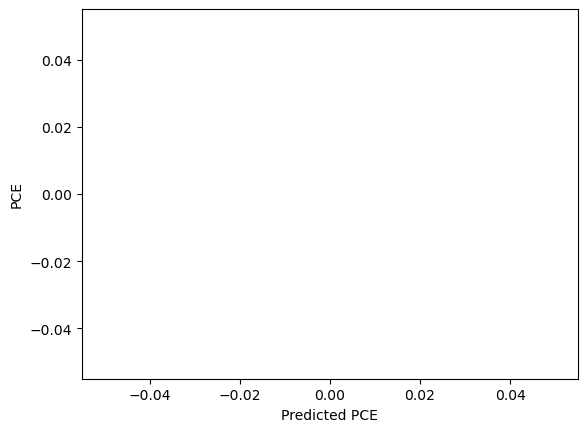

In [29]:
if __name__ == '__main__':
    # status = main() 
    # db = write_train_db()
    test_model_from_db(db)

In [14]:
def old_main():
    target=['et1','dhomo','dlumo','homo','lumo'] # need to predict with schnet; i.e. need SLI-GNN to get these ppties
    target2=['nd','edahl','edall','adlumo'] # no need to predict; can compute these ppties from the above targets and by knowing the acceptor
    predata={} # dict of dicts, where the 'outer' dict keys are acceptor IDs and the values are dicts containing their molecular ppties (and the acceptor type)
    db=ase.db.connect('pred2.db') #output database where results get written to
    
    odb=ase.db.connect('train2.db') #input database containing all of the structures of the starting compounds

    # Copy structures from input db to output db; then only work with output db
    for mol in odb.select():      
            atom=mol.toatoms()
            db.write(atom)
    for tag in target:
        best_model=load_model(target=tag,path='./package/'+tag+'_model') #each molecular property has its own model to predict it
    
        for property,id in pred_data(best_model,tag,data='pred2.db'):
            for sid,sprop in zip(id,property):    
                predata.update({sid[0]:{tag:sprop[0]}}) #add property:value pair to each molecule one property at a time (sprop is a singleton)
        write_results(predata,tag,db)    
#         print(predata)
    for tag in target2:
        for moln,molo in zip(db.select(),odb.select()): #molecules in both databases are ordered in the same way, so `molo` and `moln` refer to the same molecule; need to `molo`` (from input db `odb`) because it contains info about the acceptor
            sprop=cal_prop(moln,molo,tag)
            print(f'moln.id = {moln.id}\tmolo.id = {molo.id}')
            sid=moln.id-1 # for zero indexing?
            predata.update({sid:{tag:sprop}})
           
        write_results(predata,tag,db) #save molecules and their properties to a '.db' file
    pcemodel=load_model(target='PCE',path='./package/lgb_model')
    
    ids,pce=pred_data(model=pcemodel,tag='PCE',data='pred2.db')

    for sid,spce in zip(ids,pce):
        
        db.update(id=sid,PCE=spce)

    
    return 0

In [15]:
model_paths = ['weights/lgb_model','weights/PCE_model']
for mp in model_paths:
    print(f'----- {mp} -----')
    model = joblib.load(mp)
    print(type(model))
    pdict = model.get_params()
    for key in pdict.keys():
        print(f'{key} ---> {pdict[key]}')
    print('\n\n')


----- weights/lgb_model -----
<class 'lightgbm.sklearn.LGBMRegressor'>
boosting_type ---> gbdt
class_weight ---> None
colsample_bytree ---> 1.0
importance_type ---> split
learning_rate ---> 0.14591836734693878
max_depth ---> 9
min_child_samples ---> 13
min_child_weight ---> 0.001
min_split_gain ---> 0.0
n_estimators ---> 39
n_jobs ---> -1
num_leaves ---> 35
objective ---> None
random_state ---> 399
reg_alpha ---> 0.6555
reg_lambda ---> 0.0
subsample ---> 1.0
subsample_for_bin ---> 200000
subsample_freq ---> 0



----- weights/PCE_model -----
<class 'lightgbm.sklearn.LGBMRegressor'>
boosting_type ---> gbdt
class_weight ---> None
colsample_bytree ---> 1.0
importance_type ---> split
learning_rate ---> 0.14591836734693878
max_depth ---> 9
min_child_samples ---> 13
min_child_weight ---> 0.001
min_split_gain ---> 0.0
n_estimators ---> 39
n_jobs ---> -1
num_leaves ---> 35
objective ---> None
random_state ---> 399
reg_alpha ---> 0.6555
reg_lambda ---> 0.0
subsample ---> 1.0
subsample_for_bin -